In [120]:
import numpy as np
import pandas as pd
import random
import seaborn
import torch
import torch.nn as nn

from tqdm.notebook import tqdm

# Create Dataset

This will work by simulating a playing field of a given size, giving a random starting position to a "ball" on the playing field, and a velocity vector: `(vx, vy)`. It will simulate for N `steps`, moving and bouncing the ball off the walls and return a dictionary with the input playfield size `(width, height)` and all the collected positions (`(x, y)`) in order of time.

In [121]:
def build_dataset(w, h, steps=500):
    x = random.randrange(0, w)
    y = random.randrange(0, h)
    
    # random velocity
    vx = random.choice([-1, 1])
    vy = random.choice([-1, 1])

    # initial position
    positions = [(x, y)]

    # simulate
    for i in range(steps):
        x += vx
        y += vy

        # bounce off walls
        if x < 0 or x >= w:
            x -= vx
            vx = -vx

        if y < 0 or y >= h:
            y -= vy
            vy = - vy
        
        # update dataset
        positions.append((x, y))
    
    return {
        'size': (w, h),
        'positions': positions,
    }

training_dataset = build_dataset(113, 73)
validation_dataset = build_dataset(113, 73)

# Run on GPUs if possible

In [122]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

# Define the Model

The model is an LSTM that takes a time series of positions and attempts to predict the next position where the ball will be when done.

In [137]:
class PongModel(nn.Module):

    def __init__(self, window_size, dropout=0):
        super().__init__()

        # number of input and output features: x and y
        self.input_size = 2
        self.output_size = 2

        # number of time steps (stacked LSTM cells)
        self.window_size = window_size
        self.num_layers = window_size

        # number of features in the last hidden state (number of time steps to predict)
        self.hidden_size = self.input_size + 1

        # build the network
        self.rnn = nn.RNN(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)
        #self.rnn = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True, dropout=dropout)
        self.lin = nn.Linear(self.hidden_size, self.output_size)

        # if normalizing outputs to [0,1] use the activation function at the end
        self.act = nn.Sigmoid()
    
    def forward(self, x):
        """
        Expected input shape: (num_batches, window_size, input_size).
        """
        batch_size = x.size(0)

        # run the RNN/LSTM
        out, _ = self.rnn(x)

        # ensure the output shape is as expected
        assert out.shape == (batch_size, self.window_size, self.hidden_size)

        # for an RNN _ = hn
        # for an LSTM _ = (hn, cn)
        #
        # hn[-1, :, :] == out[:, -1, :]

        # get the hidden layer output of the final cell
        x = out[:, -1, :]

        # ensure it's the expected shape
        assert x.shape == (batch_size, self.hidden_size)
        
        # compress the output into an (x, y) position
        x = self.lin(x)
        x = self.act(x)

        return x

# Create Batches from Dataset

Given a dataset of in-order, time-series positions, create "windows" (batches) that can be sent to the model along with the known prediction (next position) to train/validate against.

In [124]:
def get_windows(dataset, window_size=10):
    """
    Return a list of windows.

    Each window is a tuple of (inputs, prediction). The inputs are the in-order, time step
    positions of the ball. The prediction is the known, next position of the ball after
    the window.
    """
    positions = dataset['positions']
    n = window_size

    return [(positions[i:i+n], positions[i+n]) for i in range(len(positions) - n - 1)]

def get_inputs(window):
    """
    Returns a np.array of shape (window_size, position) for a given window.
    """
    return np.vstack([np.array(pos, dtype=np.float32) for pos in window[0]])

def get_prediction(window):
    """
    Returns an np.array of shape [2] with the predicted (x, y) of the next time point after
    the window.
    """
    return np.array(window[1], dtype=np.float32)

def get_batches(dataset, window_size, batch_size):
    """
    Returns a generator yielding (input_batch, prediction_batch).
    """
    windows = get_windows(dataset, window_size)

    # create an array of indices to randomize the batches
    indices = np.arange(len(windows))
    np.random.shuffle(indices)

    # limit the indices to a multiple of the batch_size
    indices = indices[:len(indices) - (len(indices) % batch_size)]

    # for each window, get the inputs and prediction
    inputs = [get_inputs(w) for w in windows]
    predictions = [get_prediction(w) for w in windows]

    # split the indices into batches
    batches = np.split(indices, len(windows) // batch_size)

    # yield each batch of inputs and predictions
    for batch in batches:
        batched_inputs = [inputs[i] for i in batch]
        batched_predictions = [predictions[i] for i in batch]

        yield (np.stack(batched_inputs), np.vstack(batched_predictions))

def get_normalized_batches(dataset, window_size, batch_size):
    """
    Normalizes all the positions and predictions of all windows to [0, 1].
    """
    size = np.array(dataset['size'], dtype=np.float32)

    # normalize each batch
    for inputs, prediction in get_batches(dataset, window_size, batch_size):
        normalized_inputs = inputs / size
        normalized_prediction = prediction / size

        yield (normalized_inputs, normalized_prediction)

# Create a Model and Run Test Batch

This is to test input and output shapes.

In [125]:
model = PongModel(window_size=4)

# create a test batch and run it through to confirm shapes
(test_inputs, test_prediction) = next(get_batches(training_dataset, model.window_size, 5))

# ensure the inputs are the correct shape: (batch_size, window_size, input_size)
assert test_inputs.shape == (5, model.window_size, model.input_size), f'Input shape {test_inputs.shape} wrong!'

# run the input through the model
output = model(torch.from_numpy(test_inputs))

# the test_prediction should be the same shape as the output: (batch_size, output_size)
assert output.shape == test_prediction.shape
assert output.shape == (5, model.output_size)

# Train Model and Validate

In [152]:
def train_epoch(model, batches):
    """
    Train a single epoch for a target stock.
    """
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    running_loss = 0

    # run training
    for inputs, prediction in batches:
        optimizer.zero_grad()

        # input and prediction tensors
        x = torch.from_numpy(inputs).to(device)
        y = torch.from_numpy(prediction).to(device)

        # run the model
        output = model(x)

        # calculate the loss
        loss = loss_fn(output, y)

        # run backpropogation
        loss.backward()
        optimizer.step()

        # calculate the running loss for the batch
        running_loss += loss.max().item()
    
    # TODO: run validation?

    return running_loss

def train(model, batches, num_epochs):
    """
    Continue training a model for a target stock.
    """
    training_loss = [(i, train_epoch(model, batches)) for i in tqdm(range(num_epochs))]

    # create a dataframe tracking epoch and loss
    loss_df = pd.DataFrame(training_loss, columns=['epoch', 'loss'])
    
    # plot the loss
    return seaborn.lineplot(loss_df, x='epoch', y='loss')

# Create, Train, and Validate a Model

In [138]:
model = PongModel(window_size=4)

  0%|          | 0/1000 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='loss'>

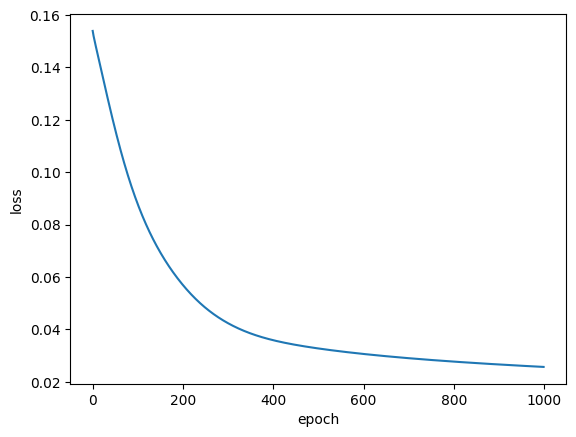

In [157]:
# move the model the the GPU for training
model = model.to(device)

# generate all the batches for training
training_batches = list(get_normalized_batches(training_dataset, model.window_size, batch_size=5))

# train the model - this cell may be run many times
train(model, training_batches, num_epochs=1000)

# Plot output vs. predicted positions

<Axes: xlabel='x', ylabel='y'>

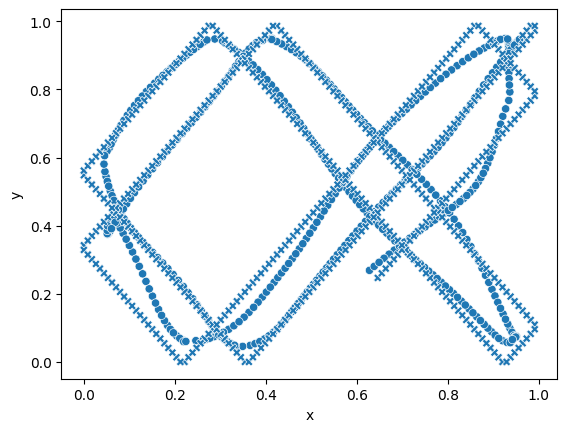

In [158]:
# move the model to the CPU to validating
model = model.to('cpu')

outputs = []
predictions = []

# collect all the outputs and predictions
for inputs, prediction in get_normalized_batches(validation_dataset, model.window_size, 1):
    output = model(torch.from_numpy(inputs))

    # collect the output positions
    outputs.append(output[0].detach().numpy())

    # collect the predicted positions
    predictions.append(prediction[0])

# convert them to np.arrays
outputs = np.vstack(outputs)
predictions = np.vstack(predictions)

# get the outputs and the predictions
outputs_df = pd.DataFrame({'x': outputs[:, 0], 'y': outputs[:, 1]}).assign(dataset='output')
predictions_df = pd.DataFrame({'x': predictions[:, 0], 'y': predictions[:, 1]}).assign(dataset='prediction')

# join the data together
df = pd.concat([outputs_df, predictions_df])

# plot them as two different datasets
seaborn.scatterplot(df, x='x', y='y', style='dataset', legend=False)